In [1]:
from collections import namedtuple
import iris
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
import numpy as np
from path import Path
import string
# My packages
import arke
# Local scripts
import mypaths

##  Common settings

In [2]:
plt.style.use('./paperfig.mplstyle')

In [3]:
um_res = arke.units.GrdStep('km2p2')

## Input data

In [4]:
PLOTDIR = mypaths.plotdir

In [5]:
FNAME_MASK = 'umnsa_*'
TOPDIR = mypaths.umdatadir
PATH_MASK = TOPDIR / '{fcst_init}' / '{um_res}' / '{idir}' / '{subdir}'
PATH_MASK /= FNAME_MASK

In [6]:
pl_cases = dict(STARS72='20070404T1200Z',
                STARS77='20080129T1200Z')

In [7]:
def load_single_time(uris, constraint):
    cl = iris.load(uris, constraints=constraint)
    res = iris.cube.CubeList()
#     with warnings.filterwarnings('ignore', 'IrisDeprecation')
#     with iris.FUTURE.context(cell_datetime_objects=False):
    for cube in cl:
        res.append(cube.extract(iris.Constraint(time=cube.coord('time').cell(0).point)))
    return res

In [8]:
cases = ('ctrl', 'ice76n')
# fcst_str = '20070404T1200Z'
fcst_str = '20080129T1200Z'

In [9]:
vrbls = ['surface_altitude', 'sea_ice_area_fraction', 'surface_temperature']
add_vrbls = [] # ['x_wind', 'y_wind']

In [10]:
cubelists = dict()  # iris.cube.CubeList()

# def add_scalar_coord_at_load(cube, field, filename):
#     cube.add_aux_coord(iris.coords.AuxCoord(case, long_name='run'))

for case in cases:
    cubelists[f'{case}'] = load_single_time(PATH_MASK.format(fcst_init=fcst_str,
                                                             idir=case,
                                                             subdir='sfc',
                                                             um_res=um_res),
                                            vrbls)
    cl = iris.load(PATH_MASK.format(fcst_init=fcst_str, idir=case,
                                                        subdir='sfc',
                                                        um_res=um_res),
                   constraints=add_vrbls)
    cubelists[f'{case}'] += cl

In [11]:
# case = 'ctrl'
# other_fcst_init = '20080129T1200Z'

# cubelists[f'{other_fcst_init}_{case}'] = load_single_time(TOPDIR/other_fcst_init/f'{um_res}'/case/'sfc'/'umnsa*00*', vrbls)

In [12]:
cubes = iris.cube.CubeList()
for case, cl in cubelists.items():
    for cube in cl:
        cube.add_aux_coord(iris.coords.AuxCoord(case, long_name='run'))
        cubes.append(cube)
cl = cubes.merge()

for cube in cl:
    cube.add_dim_coord(iris.coords.DimCoord([*range(len(cubelists))], long_name='run_id'), 0)

## Plot

In [13]:
alt, siaf, surftemp = cl.extract(vrbls)

In [14]:
orog_cmap = plt.cm.gray
orog_cmap.set_under(alpha=0)

In [15]:
def add_circ_arrows(ax, x, y, dx, clockwise=False, **arrowprops):
    ang = 0
    if clockwise:
        incr = -90
    else:
        incr = 90
    for _ in range(4):
        old_ang = ang
        ang += incr
        xytext = (x+dx*np.cos(np.deg2rad(old_ang)),
                  y+dx*np.sin(np.deg2rad(old_ang)))
        xy = (x+dx*np.cos(np.deg2rad(ang)),
              y+dx*np.sin(np.deg2rad(ang)))
        angleA = np.rad2deg(np.arcsin(np.sin(np.deg2rad(ang))))
        angleB = np.rad2deg(np.arccos(np.sin(np.deg2rad(ang))))
        arrowprops['connectionstyle'] = f"angle3,angleA={angleA},angleB={angleB}"
        ax.annotate('',
                    xy=xy, xycoords='data',
                    xytext=xytext, textcoords='data',
                    arrowprops=arrowprops)

In [16]:
SchemeLabel = namedtuple('SchemeLabel', ['x', 'y', 'name', 'size', 'kwargs', 'arrowprops'])

In [17]:
Arrow = namedtuple('Arrow', ['xy0', 'xy1', 'arrowprops'])

In [18]:
large_arrow_style = 'fancy,head_length=1.5,head_width=1.5,tail_width=2'

In [19]:
x0 = 150
y1 = 100

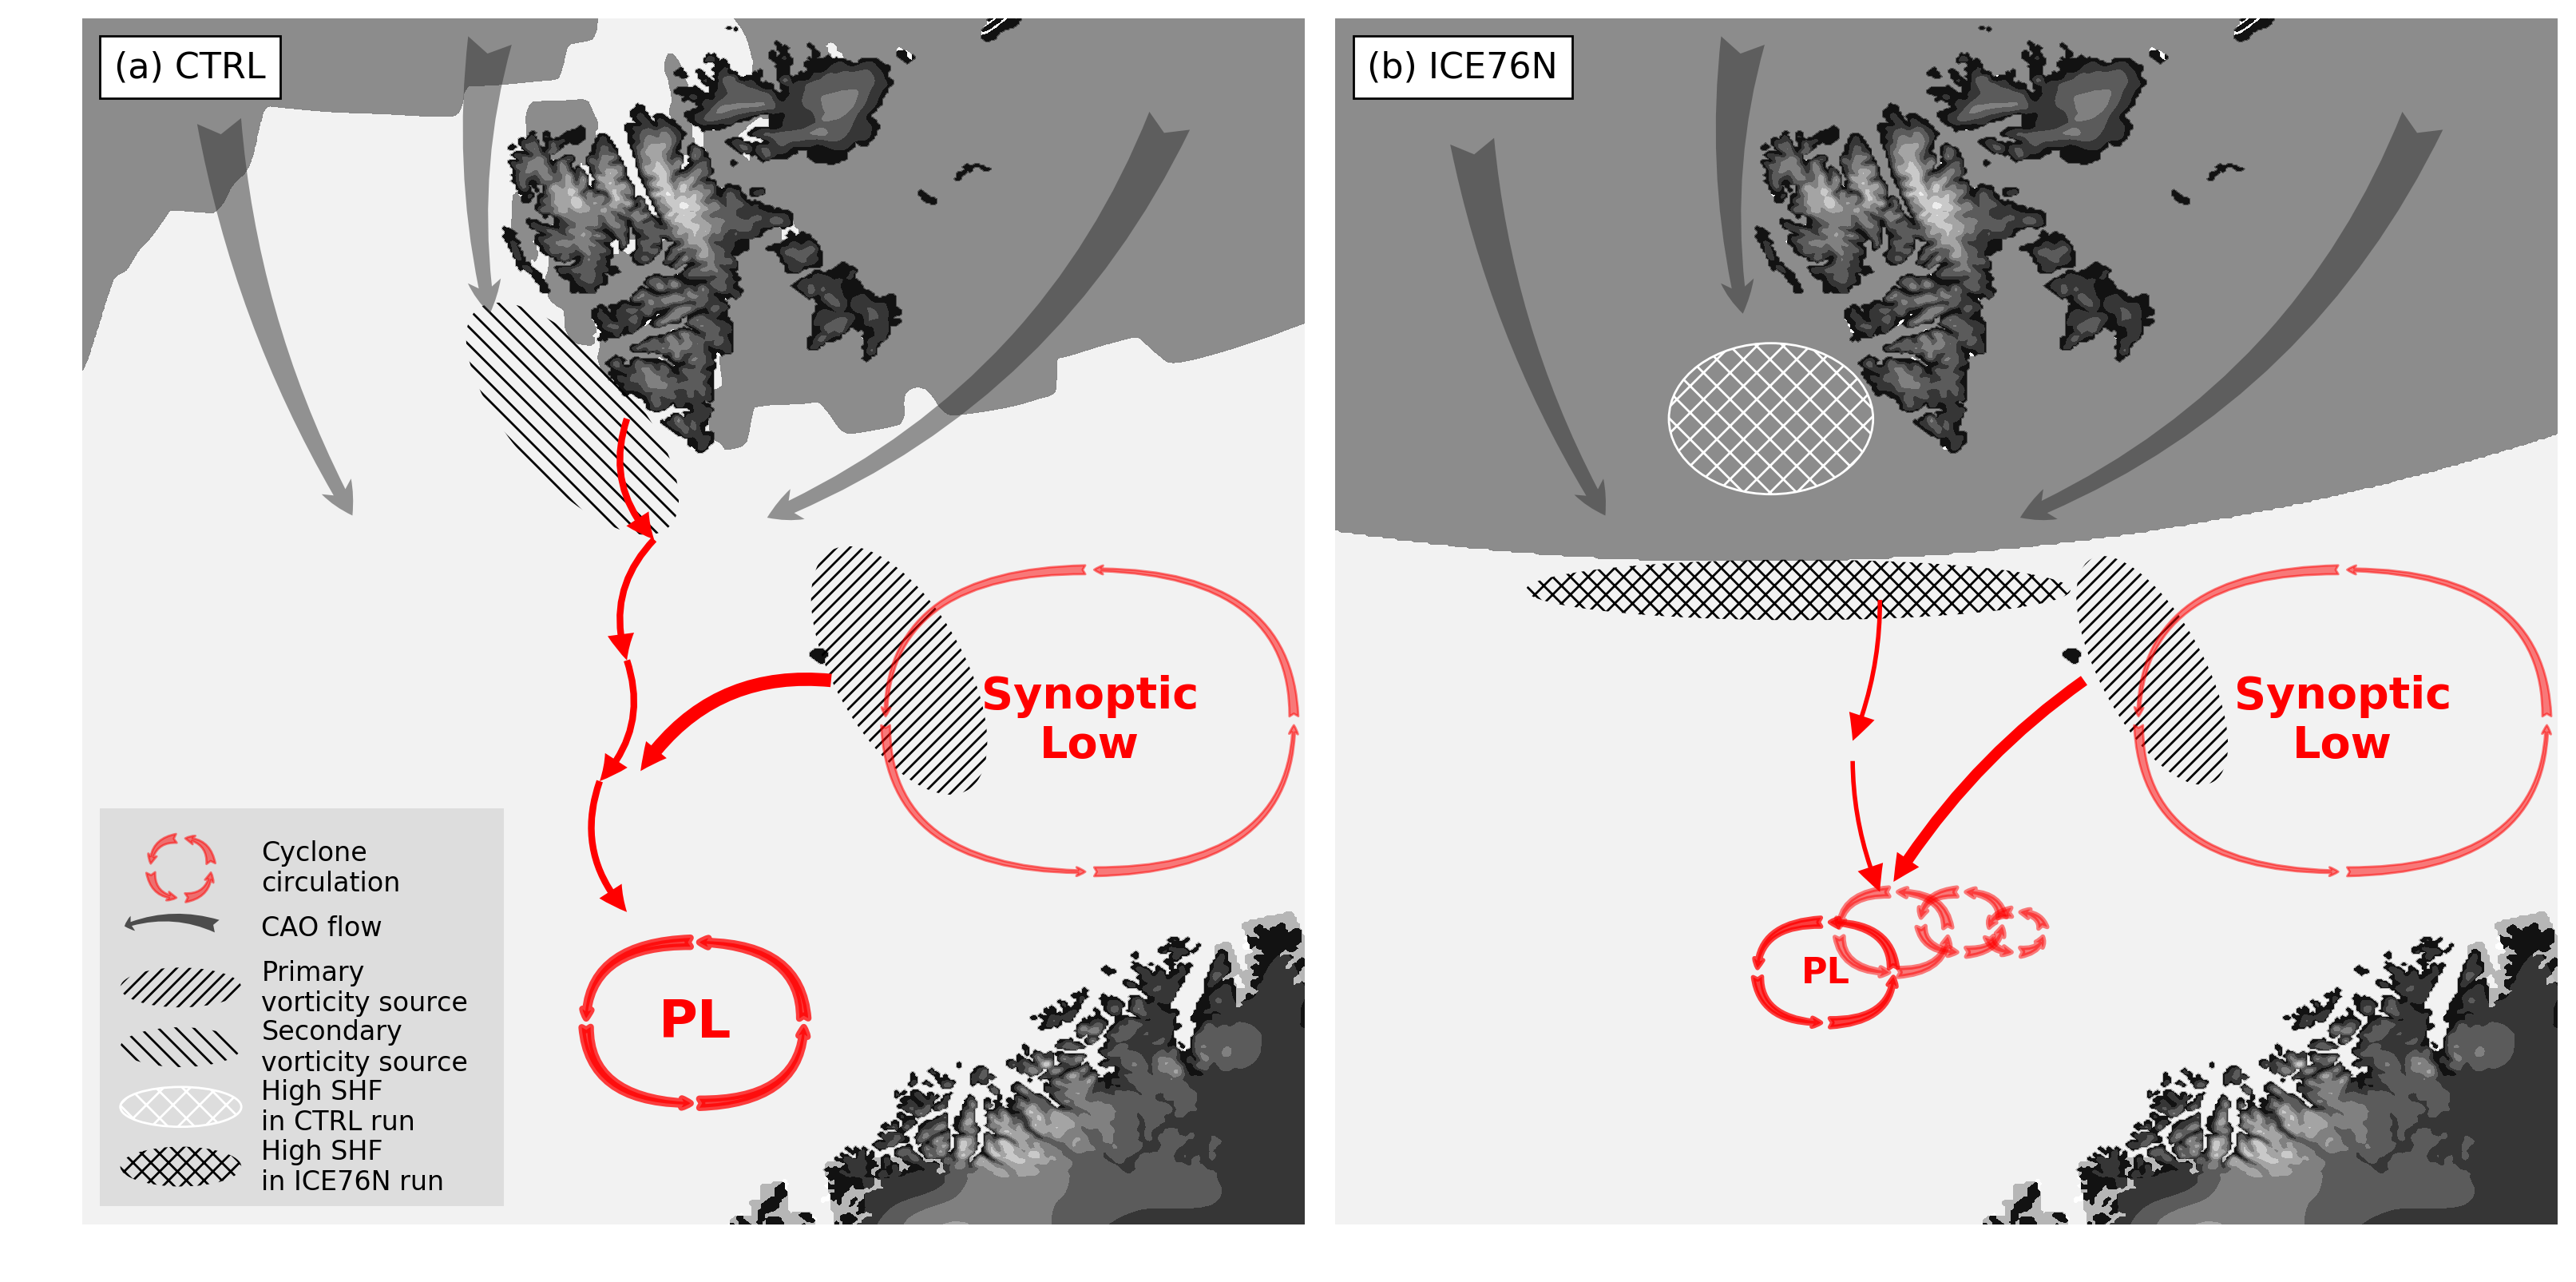

In [20]:
ncol = 2
nrow = 1
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*10, nrow*10))
ax_labels = iter(string.ascii_lowercase)
for ax, case in zip(axs.flat, cases):
    txt = f'({next(ax_labels)}) {case.upper()}'
    at = AnchoredText(txt, prop=dict(size=16), frameon=True, loc=2)
    ax.add_artist(at)
fig.subplots_adjust(wspace=0.025)
for ax, run in zip(axs, cases):
    ax.axis('off')
#     ax.grid(True)
    runc = iris.Constraint(run=run)
    ax.contourf(alt.extract(runc).data[:-y1, x0:], cmap=orog_cmap, levels=np.arange(0, 1600, 200), extend='max')
    ax.contourf(siaf.extract(runc).data[:-y1, x0:], levels=[0, 0.15, 1], colors=['#EEEEEE', '#666666'], alpha=0.75)

        
ax = axs[0]
label_list = [
    SchemeLabel(520-x0, 250, 'Synoptic\nLow', 75,
                dict(color='#FF0000', fontweight='bold', size=20, va="center", ha="center"),
                arrowprops=dict(arrowstyle='fancy', linewidth=1, color='#FF0000', alpha=0.5)),
    SchemeLabel(375-x0, 100, 'PL', 40,
                dict(color='#FF0000', fontweight='bold', size=24, va="center", ha="center"),
                arrowprops=dict(arrowstyle='fancy', linewidth=3, color='#FF0000', alpha=0.75))
]
ell_list = [
    mpatches.Ellipse((330-x0, 400), 50, 130, angle=30, fc='none', hatch='\\\\\\'),
    mpatches.Ellipse((450-x0, 275), 50, 130, angle=20, fc='none', hatch='////')
]

arrowlist = [
    Arrow((360-x0, 340), (350-x0, 400), 
          dict(connectionstyle='arc3,rad=0.3', ec='none', width=3, fc='#FF0000')),
    Arrow((350-x0, 280), (360-x0, 340), 
          dict(connectionstyle='arc3,rad=0.3', ec='none', width=3, fc='#FF0000')),
    Arrow((340-x0, 220), (350-x0, 280), 
          dict(connectionstyle='arc3,rad=-0.3', ec='none', width=3, fc='#FF0000')),
    Arrow((350-x0, 155), (340-x0, 220), 
          dict(connectionstyle='arc3,rad=0.3', ec='none', width=3, fc='#FF0000')),
    
    Arrow((355-x0, 225), (425-x0, 270),
          dict(connectionstyle='arc3,rad=0.3', ec='none', width=6, fc='#FF0000')),
#     Arrow((150-x0, 250), (100-x0, 550),
#           dict(connectionstyle='arc3,rad=-0.1', arrowstyle=large_arrow_style, ec='none', fc='#333333', alpha=0.5)),
    Arrow((250-x0, 350), (200-x0, 550),
          dict(connectionstyle='arc3,rad=0.1', arrowstyle=large_arrow_style, ec='none', fc='#333333', alpha=0.5)),
    Arrow((300-x0, 450), (300-x0, 590),
          dict(connectionstyle='arc3,rad=0.1', arrowstyle=large_arrow_style, ec='none', fc='#333333', alpha=0.5)),
    Arrow((400-x0, 350), (550-x0, 550),
          dict(connectionstyle='arc3,rad=-0.2', arrowstyle=large_arrow_style, ec='none', fc='#333333', alpha=0.5)),
]

for sl in label_list:
    ax.annotate(sl.name, xy=(sl.x, sl.y), xycoords='data', **sl.kwargs)
    add_circ_arrows(ax, sl.x, sl.y, dx=sl.size, **sl.arrowprops)

for el in ell_list:
    ax.add_artist(el)

for arr in arrowlist:
    ax.annotate('',
                xy=arr.xy0, xycoords='data',
                xytext=arr.xy1, textcoords='data',
                arrowprops=arr.arrowprops)

# SECOND SUBPLOT
ax = axs[1]
ell_list = [
#     mpatches.Ellipse((330, 400), 40, 120, angle=30, fc='none', hatch='//'),
    mpatches.Ellipse((450-x0, 275), 40, 120, angle=20, fc='none', hatch='////'),
    mpatches.Ellipse((320-x0, 315), 30, 200, angle=90, fc='none', hatch='xxx'),
    mpatches.Ellipse((310-x0, 400), 75, 75, angle=90, fc='none', ec='w', hatch='xx')
]

arrowlist = [
    Arrow((340-x0, 240), (350-x0, 310),
          dict(connectionstyle='arc3,rad=-0.1', ec='none', width=2, fc='#FF0000')),
    Arrow((350-x0, 165), (340-x0, 230), 
          dict(connectionstyle='arc3,rad=0.1', ec='none', width=2, fc='#FF0000')),
    Arrow((355-x0, 170), (425-x0, 270),
          dict(connectionstyle='arc3,rad=0.1', ec='none', width=5, fc='#FF0000')),    
    
#     Arrow((150, 250), (100, 550),
#           dict(connectionstyle='arc3,rad=-0.1', arrowstyle=large_arrow_style, ec='none', fc='#333333', alpha=0.5)),
    Arrow((250-x0, 350), (200-x0, 540),
          dict(connectionstyle='arc3,rad=0.1', arrowstyle=large_arrow_style, ec='none', fc='#333333', alpha=0.5)),
    Arrow((300-x0, 450), (300-x0, 590),
          dict(connectionstyle='arc3,rad=0.1', arrowstyle=large_arrow_style, ec='none', fc='#333333', alpha=0.5)),
    Arrow((400-x0, 350), (550-x0, 550),
          dict(connectionstyle='arc3,rad=-0.2', arrowstyle=large_arrow_style, ec='none', fc='#333333', alpha=0.5)),
]
label_list = [
    SchemeLabel(520-x0, 250, 'Synoptic\nLow', 75,
                dict(color='#FF0000', fontweight='bold', size=20, va="center", ha="center"),
                arrowprops=dict(arrowstyle='fancy', linewidth=1, color='#FF0000', alpha=0.5)),
    SchemeLabel(330-x0, 125, 'PL', 25,
                dict(color='#FF0000', fontweight='bold', size=16, va="center", ha="center"),
                arrowprops=dict(arrowstyle='fancy', linewidth=2, color='#FF0000', alpha=0.75)),
    SchemeLabel(355-x0, 145, '', 20,
                dict(color='#FF0000', fontweight='bold', size=24, va="center", ha="center"),
                arrowprops=dict(arrowstyle='fancy', linewidth=2, color='#FF0000', alpha=0.5)),
    SchemeLabel(380-x0, 150, '', 15,
                dict(color='#FF0000', fontweight='bold', size=24, va="center", ha="center"),
                arrowprops=dict(arrowstyle='fancy', linewidth=2, color='#FF0000', alpha=0.5)),
    SchemeLabel(400-x0, 145, '', 10,
                dict(color='#FF0000', fontweight='bold', size=24, va="center", ha="center"),
                arrowprops=dict(arrowstyle='fancy', linewidth=2, color='#FF0000', alpha=0.5)),
]
for sl in label_list:
    ax.annotate(sl.name, xy=(sl.x, sl.y), xycoords='data', **sl.kwargs)
    add_circ_arrows(ax, sl.x, sl.y, dx=sl.size, **sl.arrowprops)

for el in ell_list:
    ax.add_artist(el)

for arr in arrowlist:
    ax.annotate('',
                xy=arr.xy0, xycoords='data',
                xytext=arr.xy1, textcoords='data',
                arrowprops=arr.arrowprops)
    
# LEGEND AXES
axins = inset_axes(axs[0],
                   width="33%", 
                   height="33%",
                   loc=3)
axins.set_facecolor('#DDDDDD')

anno_font_kw = dict(ha='left', va='center', fontsize=12)
add_circ_arrows(axins, 0.2, 0.85, dx=0.075, **dict(arrowstyle='fancy', linewidth=1, color='#FF0000', alpha=0.5))
axins.annotate('Cyclone\ncirculation', (0.4, 0.85), **anno_font_kw)

axins.annotate('',
               xy=(0.05, 0.70), xycoords='data',
               xytext=(0.3, 0.70), textcoords='data',
               arrowprops=dict(connectionstyle='arc3,rad=0.2', arrowstyle='fancy,head_width=0.7,tail_width=0.6', ec='none', fc='#333333', alpha=0.85))
axins.annotate('CAO flow', (0.4, 0.70), **anno_font_kw)

axins.add_artist(mpatches.Ellipse((0.2, 0.55), 0.1, 0.3, angle=90, fc='none', hatch='////'))
axins.annotate('Primary\nvorticity source', (0.4, 0.55), **anno_font_kw)

axins.add_artist(mpatches.Ellipse((0.2, 0.4), 0.1, 0.3, angle=90, fc='none', hatch='\\\\\\'))
axins.annotate('Secondary\nvorticity source', (0.4, 0.4), **anno_font_kw)

axins.add_artist(mpatches.Ellipse((0.2, 0.25), 0.1, 0.3, angle=90, fc='none', ec='w', hatch='xx'))
axins.annotate('High SHF\nin CTRL run', (0.4, 0.25), **anno_font_kw)

axins.add_artist(mpatches.Ellipse((0.2, 0.1), 0.1, 0.3, angle=90, fc='none', hatch='xxx'))
axins.annotate('High SHF\nin ICE76N run', (0.4, 0.1), **anno_font_kw)

# axins.axis('off');
# axins.xaxis.set_ticks_position('none')
# axins.yaxis.set_ticks_position('none')
axins.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    left='off',         # ticks along the top edge are off
    right='off',         # ticks along the top edge are off
    labelleft='off',
    labelbottom='off') # labels along the bottom edge are off
for sp in axins.spines.values():
    sp.set_visible(False)

In [21]:
# # NOSVA
# nosva_vortices_xy = [
#     (50, 60),
#     (75, 80),
#     (100, 95),
#     (125, 75),
#     (150, 50),
#     (175, 60),

# ]
# nosva_color = '#FF7777'
# for xy in nosva_vortices_xy:
#     add_circ_arrows(ax, *xy, dx=15, **dict(arrowstyle='fancy', linewidth=0.1, color=nosva_color, alpha=0.75))

# ax.text(200, 225, "Vorticity advection\nwithout Svalbard",
#         ha="center", va="center", color=nosva_color, alpha=0.9, fontweight='bold', rotation=60, size=15,
#         bbox=dict(boxstyle="larrow", pad=1, linestyle='--', fc='none', ec=nosva_color, alpha=0.75, lw=5))

In [22]:
fig.savefig(mypaths.plotdir / 'schematic')